/tmp/ipykernel_48678/3133570660.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
/tmp/ipykernel_48678/3133570660.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Selected Features: Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'alone', 'sex_male',
       'embarked_Q', 'embarked_S'],
      dtype='object')
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.7932960893854749
Recall: 0.7432432432432432
Precision: 0.7534246575342466
F1 Score: 0.7482993197278912
Specificity: 0.8285714285714286
AUC: 0.8837837837837836


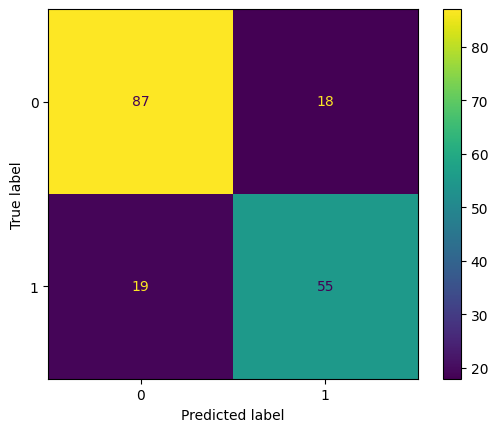

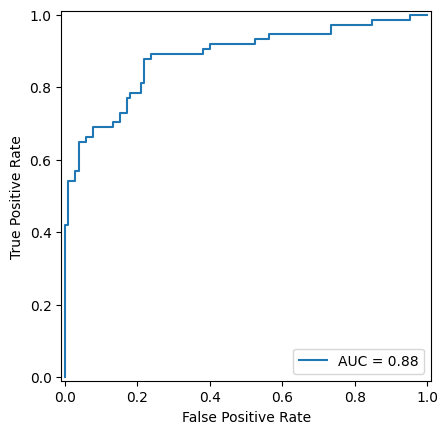

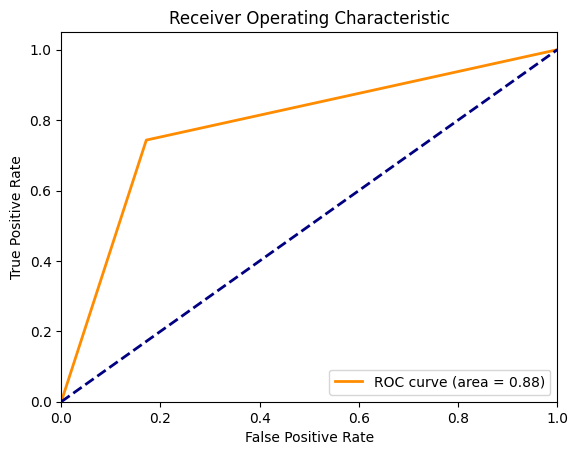

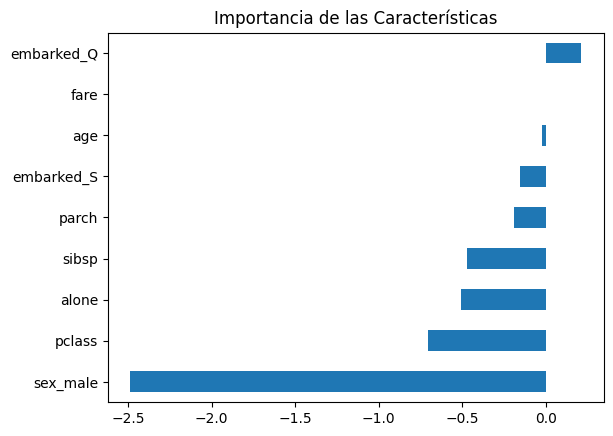

In [7]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, recall_score, precision_score, f1_score, 
                             confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay)
import matplotlib.pyplot as plt

# Cargar el dfset del Titanic desde seaborn
df = sns.load_dataset('titanic')

# Preprocesamiento de datos
# Eliminar columnas irrelevantes
df.drop(columns=['deck', 'embark_town', 'alive', 'class', 'who', 'adult_male'], inplace=True)

# Rellenar valores nulos
df['age'].fillna(df['age'].median(), inplace=True)
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)
df['fare'].fillna(df['fare'].median(), inplace=True)

# Codificar variables categóricas
df = pd.get_dummies(df, drop_first=True)

# Separar características y variable objetivo
X = df.drop(columns=['survived'])
y = df['survived']

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Selección de características con RFE
model = LogisticRegression(max_iter=1000)
selector = RFE(model, n_features_to_select=10)
selector = selector.fit(X_train, y_train)

# Características seleccionadas
selected_features = X_train.columns[selector.support_]
print(f'Selected Features: {selected_features}')

# Transformar los conjuntos de datos
X_train_selected = pd.DataFrame(selector.transform(X_train), columns=selected_features)
X_test_selected = pd.DataFrame(selector.transform(X_test), columns=selected_features)

# Ajuste de hiperparámetros con GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_selected, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
print(f'Best Parameters: {grid_search.best_params_}')

# Balanceo de datos con SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

# Entrenar el mejor modelo con los datos balanceados
best_model.fit(X_train_balanced, y_train_balanced)

# Realizar predicciones
y_pred = best_model.predict(X_test_selected)
y_pred_prob = best_model.predict_proba(X_test_selected)[:, 1]

# Calcular las métricas
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Especificidad
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

# Calcular AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Imprimir métricas
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print(f'Specificity: {specificity}')
print(f'AUC: {roc_auc}')

# Graficar matriz de confusión
ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

# Graficar curva ROC
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.show()
# Curva ROC
plt.figure()
lw = 2
plt.plot(roc_curve(y_test, y_pred)[0], roc_curve(y_test, y_pred)[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()




# Importancia de las características
importancia_caracteristicas = pd.Series(best_model.coef_[0], index=selected_features)
importancia_caracteristicas.sort_values().plot(kind='barh')
plt.title('Importancia de las Características')
plt.show()
